# Description 

This script allows to download remote sensing data from the CCI
dataset for a single lake according to user defined period. 
The zone will be defined by de boundaries of the polygon defining the lake. 
If there are other lakes near the specified one, they will be masked.
This script is useful for dowloading data for a single lake. Information 
about its boundaries is not required.



INPUT:
    <ul>
    <li>The identifier of the lake. The id of the lake is indicated 
      in the csv file containing lake metadata. This file is available 
      at the project website:
       https://climate.esa.int/documents/2607/lakescci_v2.1.0_metadata.csv</li>
    <li>Land mask: the netCDF file containing the mask of the lakes in CCI dataset this file 
      is part of the dataset and is available at:
      https://dap.ceda.ac.uk/neodc/esacci/lakes/data/lake_products/L3S/v2.0.1/ESA_CCI_static_lake_mask_v2.0.1.nc</li>
    <li>first/last date</li>
    <li>version of the dataset to be download (default value 2.0.1)</li>
    <li>ouptput dir to storage the extracted data</li>
    <li>prefix (optional): to be added at the output files name</li>
    </ul>

 Reference: Carrea, L.; Crétaux, J.-F.; Liu, X.; Wu, Y.; Bergé-Nguyen,
 M.; Calmettes, B.; Duguay, C.; Jiang, D.; Merchant, C.J.; Mueller, D.;
 Selmes, N.; Simis, S.; Spyrakos, E.; Stelzer, K.; Warren, M.; Yesou,
 H.; Zhang, D. (2022): ESA Lakes Climate Change Initiative (Lakes_cci):
 Lake products, Version 2.0.1. NERC EDS Centre for Environmental Data
 Analysis, date of citation.
 
https://dx.doi.org/10.5285/7fc9df8070d34cacab8092e45ef276f1

 WARNING: This is a beta version. All controls on the input parameters
 are not (yet) available. If you find a bug, have a question or a
 suggestion, don't hesitate to contact us, it will be much appreciated :
 cci_lakes.contact@groupcls.com

 to be executed with python version >= 3.9

In [11]:
import os
import numpy as np
import xarray as xr
import datetime
import matplotlib.pyplot as plt
%matplotlib widget
%matplotlib inline

# Step 1: Define input parameters.

In this exemple, we download data over Lake Erie (USA).

The lake identifier (12) was obtained from the csv file (https://climate.esa.int/documents/2607/lakescci_v2.1.0_metadata.csv) available in the project website: (https://climate.esa.int/fr/projects/lakes/)

In our case, we are interesteb by  data from 2019-01-01 to 2019-01-31


In [20]:
###########################################################################################
# input parameters
###########################################################################################   

# lakes mask file 
maskfile = 'ESA_CCI_static_lake_mask_v2.0.1.nc'

# Id for lake Erie: 12
lake_id = 12

# defining the period of time in string format: YYYY-MM-DD
# dates values must be between 1992-09-26 and 2020-12-31
mindate = '2019-01-01'
maxdate = '2019-01-31'

# version dataset (2.1 is the version published in July 2024)
version = '2.1'

# output
outdir = 'output/Erie'
outprefix = 'Erie_'

In [13]:
# test if dates are in the temporal coverage

mindate = datetime.datetime.strptime(mindate, '%Y-%m-%d')
maxdate = datetime.datetime.strptime(maxdate, '%Y-%m-%d')
mindate = max([mindate, datetime.datetime(1992,9,26)])
maxdate = min([maxdate, datetime.datetime(2020,12,31)])

In [14]:
# create the output directory if it does not exist
if os.path.exists(outdir)==False:
    os.makedirs(outdir)

# Step 2: Mask creation

In this step, latitude and longitude values inside the lake are obtained from the lake mask file. The boundary values will then be used to read the data in the region covering the lake.

In [15]:

###################################################################
# create mask base on lake_id
###################################################################

mask_xr = xr.open_dataset(maskfile)
mask = mask_xr['CCI_lakeid'].values
mask_ind  = np.where(mask == lake_id)
minx = np.min(mask_ind[1][:]) - 1
maxx = np.max(mask_ind[1][:]) + 1
miny = np.min(mask_ind[0][:]) - 1
maxy = np.max(mask_ind[0][:]) + 1

mask_lake = mask[miny:maxy+1, minx:maxx+1]
mask_lake[mask_lake!=lake_id] = 0
mask_lake[mask_lake == lake_id] = 1

lat = mask_xr['lat'][miny:maxy+1].values
lon = mask_xr['lon'][minx:maxx+1].values


A good validation test is to check that the lake ID is correct by visualising the lake mask.

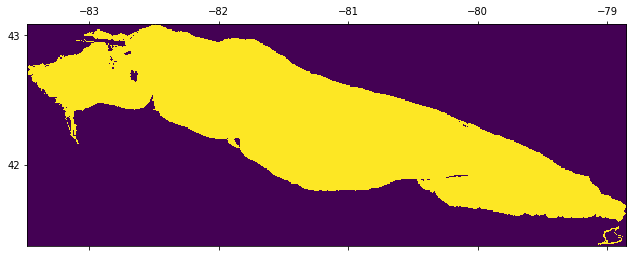

In [16]:
# plot lake mask 
plt.matshow(mask_lake, extent=[np.min(lon), np.max(lon), np.min(lat), np.max(lat)])
plt.show()

# Step 3: Data download

In this step, the data for the defined lake is is downloaded from each daily file and written, in netCDF format, to the output directory


In [ ]:
# The download process

for data_date in np.arange(mindate.toordinal(), maxdate.toordinal()+1):
    current_date = datetime.datetime.fromordinal(data_date)
    date_str = current_date.strftime("%Y%m%d")

    print (f'Downloading data from ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-{date_str}-fv{version}.nc')
    path = 'https://data.cci.ceda.ac.uk/thredds/dodsC/esacci/lakes/data/lake_products/L3S/v2.1/merged_product/'
    path += f'{current_date.year}/{current_date.month:02}/'
    path += f'ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-{date_str}-fv{version}.0.nc'
    
    
    dataset = xr.open_dataset(path, engine="pydap")
    
    # extract data in the defined zone
    dataset = dataset.isel(lat=slice(miny, maxy+1), lon=slice(minx, maxx+1))
    
     # apply mask only for varibles with three dimensions : time, lat, lon
    for var in dataset.data_vars:
        if len (dataset[var].dims) == 3 :
            filval = dataset[var].encoding['_FillValue']
            data = dataset[var][0,:,:].values
            data[mask_lake == 0] = filval
            dataset[var][0,:,:] = data
    
    # create a netcdf file
    outfile = f'{outdir}/{outprefix}ESACCI-LAKES-L3S-LK_PRODUCTS-MERGED-{date_str}-fv{version}.nc'
    dataset.to_netcdf(outfile)
